In [8]:
import datetime
import numpy as np
import matplotlib.pylab as plt
from matplotlib import cm
from chainer import Chain, Variable, cuda, optimizer, optimizers, serializers
import chainer.functions as F
import chainer.links as L
from sklearn.datasets import fetch_mldata

In [7]:
from pkg_resources import get_distribution
import platform
print("python", platform.python_version())
print("")
libs = ["numpy", "chainer", "matplotlib", "scikit-learn"]
for lib in libs:
    version = get_distribution(lib).version
    print(lib, version)

python 3.5.2

numpy 1.13.1
chainer 2.0.2
matplotlib 2.0.2
scikit-learn 0.18.2


In [3]:
# 畳み込みニューラルネットワークでMNIST画像分類

In [4]:
# モデルクラス定義

class CNN(Chain):
    def __init__(self):
        # クラスの初期化
        super(CNN, self).__init__(            
            conv1 = L.Convolution2D(None, 20, 5), # フィルター5
            conv2 = L.Convolution2D(20, 50, 5), # フィルター5
            l1 = L.Linear(800, 500),
            l2 = L.Linear(500, 500),
            l3 = L.Linear(500, 10, initialW=np.zeros((10, 500), dtype=np.float32))
        )
 
    def __call__(self, x, t=None, train=False):
        # 順伝播の計算を行う関数
        # :param x: 入力値
        # :param t: 正解のラベル
        # :param train: 学習かどうか
        # :return: 計算した損失 or 予測したラベル
        x = Variable(x)
        if train:
            t = Variable(t)
        h = F.max_pooling_2d(F.relu(self.conv1(x)), 2)
        h = F.max_pooling_2d(F.relu(self.conv2(h)), 2)
        h = F.relu(self.l1(h))
        h = F.relu(self.l2(h))
        y = F.softmax(self.l3(h))
        if train:
            loss, accuracy = F.softmax_cross_entropy(y, t), F.accuracy(y, t)
            return loss, accuracy
        else:
            return np.argmax(y.data)
 
    def reset(self):
        # 勾配の初期化
        self.zerograds()

In [6]:
# 学習

EPOCH_NUM = 5
BATCH_SIZE = 1000
 
# 教師データ
mnist = fetch_mldata('MNIST original', data_home='.')
mnist.data = mnist.data.astype(np.float32) # 画像データ　784*70000 [[0-255, 0-255, ...], [0-255, 0-255, ...], ... ]
mnist.data /= 255 # 0-1に正規化する
mnist.target = mnist.target.astype(np.int32) # ラベルデータ70000
 
# 教師データを変換
N = 60000
train_x, test_x = np.split(mnist.data,   [N]) # 教師データ
train_t, test_t = np.split(mnist.target, [N]) # テスト用のデータ
train_x = train_x.reshape((len(train_x), 1, 28, 28)) # (N, channel, height, width)
test_x = test_x.reshape((len(test_x), 1, 28, 28))
 
# モデルの定義
model = CNN()
optimizer = optimizers.Adam()
optimizer.setup(model)
 
# 学習開始
print("Train")
st = datetime.datetime.now()
for epoch in range(EPOCH_NUM):
    # ミニバッチ学習
    perm = np.random.permutation(N) # ランダムな整数列リストを取得
    total_loss = 0
    total_accuracy = 0
    for i in range(0, N, BATCH_SIZE): 
        x = train_x[perm[i:i+BATCH_SIZE]]
        t = train_t[perm[i:i+BATCH_SIZE]]
        model.reset()
        loss, accuracy = model(x=x, t=t, train=True)
        loss.backward()
        loss.unchain_backward()
        total_loss += loss.data
        total_accuracy += accuracy.data
        optimizer.update()
    ed = datetime.datetime.now()
    print("epoch:\t{}\ttotal loss:\t{}\tmean accuracy:\t{}\ttime:\t{}".format(epoch+1, total_loss, total_accuracy/(N/BATCH_SIZE), ed-st))
    st = datetime.datetime.now()

Train
epoch:	1	total loss:	110.2756325006485	mean accuracy:	0.6604166681567828	time:	0:01:45.076824
epoch:	2	total loss:	99.20416605472565	mean accuracy:	0.8088833351929983	time:	0:01:50.416151
epoch:	3	total loss:	95.10104560852051	mean accuracy:	0.8772000014781952	time:	0:01:48.486475
epoch:	4	total loss:	94.53564810752869	mean accuracy:	0.8856666634480158	time:	0:01:44.430645
epoch:	5	total loss:	89.5551906824112	mean accuracy:	0.9711333364248276	time:	0:01:47.763546



Predict


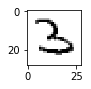

y:	3



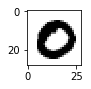

y:	0



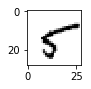

y:	5



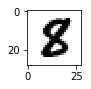

y:	8



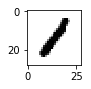

y:	1



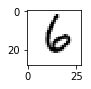

y:	6



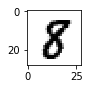

y:	8



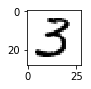

y:	3



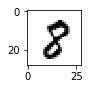

y:	8



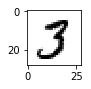

y:	3



In [9]:
# 予測

print("\nPredict")
def predict(model, x):
    y = model(x=np.array([x], dtype="float32"), train=False)
    plt.figure(figsize=(1, 1))
    plt.imshow(x[0], cmap=cm.gray_r)
    plt.show()
    print("y:\t{}\n".format(y))

idx = np.random.choice((70000-N), 10)
for i in idx:
    predict(model, test_x[i])